## Dependencies

In [0]:
# Import python standard libraries
import json
import re
from datetime import timedelta

# Import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for modeling
import xgboost as xgb
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score

# Turn off deprecated warnings
import warnings
warnings.filterwarnings('ignore')

## Data Import

**Mount data from drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import data**

In [0]:
# Parent folder of data files
abs_path = '/content/drive/My Drive/Coder_CaHop/Data/raw/null_normalized_data/tech_data'

# Import data from csv files
ads_info_data = pd.read_csv(abs_path + '/tech_ads_info.csv', index_col=0);
ads_params_data = pd.read_csv(abs_path + '/tech_ads_params.csv', index_col=0);
ads_stats_data = pd.read_csv(abs_path + '/tech_ads_stats.csv', index_col=0);

In [0]:
# Get unique adlist_id in 3 tables
ads_have_info = ads_info_data['list_id'].unique()
ads_have_params = ads_params_data['list_id'].unique()
ads_interacted = ads_stats_data['adlist_id'].unique()

# Cross-check to make sure we have infor about every ads included in log
for ad_idx in ads_have_params:
  if ad_idx not in ads_have_info:
    print('Ad #{} have params but missing infor'.format(ad_idx))
    
for ad_idx in ads_interacted:
  if ad_idx not in ads_have_info:
    print('Ad #{} are interacted but missing infor'.format(ad_idx))

**Correct inconsistent naming convention**

In [5]:
# Examine column names
print('Ads Info Columns:', ads_info_data.columns.tolist())
print('Ads Params Columns:', ads_params_data.columns.tolist())
print('Ads Stats Columns:', ads_stats_data.columns.tolist())

Ads Info Columns: ['ad_type', 'body', 'category', 'category_name', 'city', 'list_id', 'price', 'region', 'seller_type', 'subject']
Ads Params Columns: ['list_id', 'ad_id', 'name', 'value']
Ads Stats Columns: ['adlist_id', 'adplacement', 'adposition', 'adsource', 'app_os_name', 'app_os_version', 'app_version', 'browser_viewheight', 'browser_viewwidth', 'event_client_time', 'event_name', 'event_server_time', 'event_type', 'filter_brand', 'filter_category_id', 'filter_keyword', 'filter_model', 'filter_price', 'filter_region_id', 'filter_type', 'lead_type', 'page_name', 'page_number', 'page_platform', 'page_referer', 'tagging_key', 'user_fingerprint']


In [0]:
# Rename inconsistent columns
ads_info_data.rename(columns={'list_id': 'adlist_id'}, inplace=True)
ads_params_data.rename(columns={'list_id': 'adlist_id'}, inplace=True)
ads_stats_data.rename(columns={'adposition': 'ad_position', 'adsource': 'ad_source', \
                               'adplacement': 'ad_placement'}, inplace=True)

**Reindex `ads_info_data`**

In [0]:
ads_info_data.set_index('adlist_id', inplace=True)

## Data Preprocessing: `ads_stats_data`

### Data Cleaning

**Convert `event_client_time`, `event_server_time` and `filter_type` to proper format**

In [0]:
# Convert columns ended with time to datetime (data type)
ads_stats_data[['event_client_time', 'event_server_time']] = \
          ads_stats_data[['event_client_time', 'event_server_time']].apply(pd.to_datetime)

# Fill nan and convert filter_type to categorical
ads_stats_data['filter_type'] = ads_stats_data['filter_type'].fillna(value='NaN').astype('category')

**Correct inconsistent missing values encoding**

In [0]:
# Missing values are encoded with different values
ads_stats_data['filter_category_id'].replace(to_replace={0 : np.NaN}, inplace=True)
ads_stats_data['filter_region_id'].replace(to_replace={0 : np.NaN}, inplace=True)
ads_stats_data['page_number'].replace(to_replace={0: np.NaN}, inplace=True)

# Inconsistent use of language
ads_stats_data['page_name'].replace(to_replace={'TINVIEW': 'ADVIEW'}, inplace=True)

**Fill missing `page_name`**

Events of page_name 'ADLISITING' have 'adlisting' prefixed to their names. Hence, we can fill missing values in `page_name` on the basis of `event_name`.

In [0]:
def get_page_name(event_name):
  event_name = re.search(pattern='^\w+/', string=event_name)
  return event_name.group(0)[:-1].upper()

ads_stats_data['page_name'] = ads_stats_data['event_name'].apply(get_page_name)

**Standardize `event_name`**

Remove redundant information about `page_name` appended at the beginning of every `event_name`.

In [0]:
def remove_page_name(event_name):
    event_name = re.sub(pattern='^\w+/', repl='', string=event_name)
    return event_name

ads_stats_data['event_name'] = ads_stats_data['event_name'].apply(remove_page_name)

**Fill missing `ad_placement`**

Each value in ad_placement corresponds to a value in ad_source.

- `ad_placement` = 'top' ~ `ad_source` = 'stickyad'
- `ad_placement` = 'default' ~ `ad_source` = 'classifyad'
- `ad_placement` = bottom ~ `ad_source` = 'similarad').

So we can simply derive missing values on `ad_placement` based on the corresponding `ad_source`.

In [0]:
def get_ad_placement(ad_source):
  ad_placement = None
  if ad_source == 'stickyad':
    ad_placement = 'top'
  elif ad_source == 'classifyad':
    ad_placement = 'default'
  elif ad_source == 'similarad':
    ad_placement = 'bottom'
  return ad_placement

ads_stats_data.loc[ads_stats_data['ad_placement'].isnull(), 'ad_placement'] = \
  ads_stats_data[ads_stats_data['ad_placement'].isnull()]['ad_source'].apply(get_ad_placement)

In [0]:
'''Considering that there is no clear way to derive missing ad_placement and ad_source from remaining columns, 
we decided to drop rows with missing information from the data set.'''

ads_stats_data.dropna(subset=['ad_placement', 'ad_source'], inplace=True)

**Number of missing values in each column**

**Correct data type of each feature**

In [0]:
ads_stats_data['ad_placement'] = ads_stats_data['ad_placement'].astype('category')
ads_stats_data['ad_source'] = ads_stats_data['ad_source'].astype('category')

**Note: Events with missing `page_number` are view events.**

### Data Reduction

**Drop columns of low variance**

In [0]:
# Define columns to drop
drop_cols = ['app_os_name', 'app_os_version', 'app_version', 'browser_viewheight', 'browser_viewwidth', \
             'page_platform', 'page_referer', 'tagging_key', 'lead_type', 'event_client_time', 'page_name']

# Drop columns from data set
ads_stats_data = ads_stats_data.drop(columns=drop_cols)

**Remove redundant events ADVIEW_CLICK and SIMILARD_LOAD**

ADVIEW_LOAD events are triggered simultaneously with ADVIEW_CLICK as well as SIMILARAD_LOAD events.

In [0]:
ads_stats_data['event_name'].value_counts()

# Drop rows of adlisting/ADVIEW_CLICK events
ads_stats_data = ads_stats_data[~ads_stats_data['event_name'].isin(['ADVIEW_CLICK', 'SIMILARAD_LOAD'])]

**Re-target the problem, create a new feature `want_contact`**

In [0]:
def get_action(event_type):
  '''
  Suppose that all events ended with 'CLICK' (except for ADVIEW_CLICK)
  show user's positive attitude towards an ad
  '''
  
  if event_type == 'CLICK':
    contact = True
  else:
    contact = False
  return contact

# Create a new feature
ads_stats_data['contact'] = ads_stats_data['event_type'].apply(get_action)

**Drop `event_name` and `event_type`**

In [0]:
ads_stats_data.drop(columns=['event_name', 'event_type'], inplace=True)

**Observation:** Considering that a load event is always triggered before any click one, which means an ad can be marked either interested (`contact` = True) or uninterested (`contact` = False) by a user.

**Approach:** If a user showed interest in an ad, we drop all previous events of him/her on it.

In [0]:
# Create identity for each interaction of a user on a specific ad
ads_stats_data['interaction'] = ads_stats_data.apply(lambda row : \
                                                            str(row['adlist_id']) + ' ' + row['user_fingerprint'], axis=1)
# Get list of postive interactions
positive_interaction = ads_stats_data.loc[ads_stats_data['contact'] == True, 'interaction']

# Drop previous negative interactions
ads_stats_data = ads_stats_data[~((ads_stats_data['contact'] == False) & \
                                  (ads_stats_data['interaction'].isin(positive_interaction)))]

**Drop duplicate interactions of users on ads**

In [0]:
ads_stats_data.drop_duplicates(subset=['interaction', 'contact'], keep='first', inplace=True)

**Drop `interaction`**

In [0]:
ads_stats_data.drop(columns=['interaction'], inplace=True)

**Data after cleaning and dimensionality reduction**

In [22]:
ads_stats_data.isnull().sum()

adlist_id                 0
ad_placement              0
ad_position               0
ad_source                 0
event_server_time         0
filter_brand          77608
filter_category_id    13563
filter_keyword        71473
filter_model          83359
filter_price          82169
filter_region_id      11611
filter_type               0
page_number              60
user_fingerprint          0
contact                   0
dtype: int64

### Feature Engineering

**Perform label encoding on categorical columns**

In [23]:
# Examine categorical columns
categorical_cols = ads_stats_data.select_dtypes(include='object').columns

# Fill missing values in categorical columns to standard 'NaN'
ads_stats_data[categorical_cols] = ads_stats_data[categorical_cols].fillna(value='NaN')

# Check for missing values
ads_stats_data[categorical_cols].isnull().sum()

filter_keyword      0
filter_price        0
user_fingerprint    0
dtype: int64

**Sessionize events**

In [0]:
# Define session runtime
session_timedelta = timedelta(seconds=30 * 60)

# Sort events by time occured
ads_stats_data.sort_values(by='event_server_time', inplace=True)

In [0]:
# Get time of the previous event
ads_stats_data['previous_event_time'] = ads_stats_data[['event_server_time', 'user_fingerprint']] \
                                          .groupby(by='user_fingerprint').transform(lambda x : x.shift(1))

# If duration of 2 subsequent events is greater than a threshold, we mark it as a beginning of a new session
ads_stats_data['new_session'] = (ads_stats_data['previous_event_time'] - \
                                 ads_stats_data['event_server_time'] >= session_timedelta)

# Perform accumulation to find id of a session
ads_stats_data['temp_id'] = ads_stats_data.groupby(by='user_fingerprint')['new_session'].cumsum().astype(str)

# Create unique session_id by concatenate accumulated session id and user identity
ads_stats_data['session_id'] = ads_stats_data['temp_id'] + '_' + ads_stats_data['user_fingerprint']

# Drop temp columns
ads_stats_data.drop(columns=['previous_event_time', 'new_session', 'temp_id'], inplace=True)

**Create a new feature `accumulated_click`**

In [0]:
ads_stats_data['accumulated_click'] = ads_stats_data.groupby(by='session_id')['contact'].cumsum()

ads_stats_data['no_click'] = ~ads_stats_data['contact']
ads_stats_data['accumulated_load'] = ads_stats_data.groupby(by='session_id')['no_click'].cumsum()
ads_stats_data.drop(columns=['no_click'], inplace=True)

**Perform label encoding on categorical features**

In [27]:
ads_stats_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85301 entries, 199309 to 19921
Data columns (total 18 columns):
adlist_id             85301 non-null int64
ad_placement          85301 non-null category
ad_position           85301 non-null int64
ad_source             85301 non-null category
event_server_time     85301 non-null datetime64[ns]
filter_brand          7693 non-null float64
filter_category_id    71738 non-null float64
filter_keyword        85301 non-null object
filter_model          1942 non-null float64
filter_price          85301 non-null object
filter_region_id      73690 non-null float64
filter_type           85301 non-null category
page_number           85241 non-null float64
user_fingerprint      85301 non-null object
contact               85301 non-null bool
session_id            85301 non-null object
accumulated_click     85301 non-null float64
accumulated_load      85301 non-null float64
dtypes: bool(1), category(3), datetime64[ns](1), float64(7), int64(2), object(4

In [0]:
# Examine categorical columns
categorical_cols = ads_stats_data.select_dtypes(include='category').columns

# Perform label encoding
for col in categorical_cols:
  label_encoder = LabelEncoder()
  ads_stats_data[col] = label_encoder.fit_transform(ads_stats_data[col])

## Data Preprocessing: `ads_info_data`

### Data Cleaning

**Rename column `category` to `category_id`, `city` to `region_id` for more precise meaning**

In [0]:
# Rename columns for more precise meaning
ads_info_data.rename(columns={'category': 'category_id', 'city': 'region_id', 'body': 'content'}, inplace=True)

**Replace values in `category_id` with their ids**

In [0]:
# Import encoding table {region: id}
with open(abs_path + '/encode_region_preprocessing.json', encoding='UTF-8') as json_file:
  region_mapper = json.load(json_file)
  
# Drop ads with missing values in region (only 1 record)
ads_info_data.dropna(subset=['region_id'], inplace=True)
  
# Encode a region with its id
ads_info_data['region_id'] = ads_info_data['region_id'].replace(to_replace=region_mapper).astype('int')

**Convert `seller_type` to categorical**

In [0]:
ads_info_data['seller_type'] = ads_info_data['seller_type'].astype('category')

### Data Reduction

**Assumption:** Users don't want to be recommended an item with no price assigned.

**Approach:** Drop rows with missing prices.

In [32]:
# Get list of ad whose price missing
no_price_listid = ads_info_data[ads_info_data['price'].isnull()].index

# Get number of users showed interests in ads with missing price
ads_stats_data[ads_stats_data['adlist_id'].isin(no_price_listid)]['contact'].value_counts()

False    506
Name: contact, dtype: int64

In [0]:
# Remove parameters and events of regarding ads
ads_params_data = ads_params_data[~ads_params_data['adlist_id'].isin(no_price_listid)]
ads_stats_data = ads_stats_data[~ads_stats_data['adlist_id'].isin(no_price_listid)]

# Remove information of ads with missing price from data set
ads_info_data.dropna(subset=['price'], inplace=True)

**Assumption:** An ad with empty content will less likely to interest users.

**Approach:** Check if number of parameters of ads with missing content are enough to inform user what the item looks like.

In [34]:
# Get list of ads whose contect missing
no_content_listid = ads_info_data[ads_info_data['content'].isnull()].index

# Get number of users showed interests in ads with missing content
ads_stats_data[ads_stats_data['adlist_id'].isin(no_content_listid)]['contact'].value_counts()

False    2023
True        3
Name: contact, dtype: int64

In [0]:
# Remove parameters and events of regarding ads
ads_params_data = ads_params_data[~ads_params_data['adlist_id'].isin(no_content_listid)]
ads_stats_data = ads_stats_data[~ads_stats_data['adlist_id'].isin(no_content_listid)]

# Remove information of ads with missing content from data set
ads_info_data.dropna(subset=['content'], inplace=True)

**Drop ads of `buy` type since we focus on building recommender engine for buyer**

In [0]:
# Get adlist_id (unique) of buy ads
ads_buy_listid = ads_info_data[ads_info_data['ad_type'] == 'buy'].index

# Drop ads of buy type from 3 data sets
ads_stats_data = ads_stats_data[~ads_stats_data['adlist_id'].isin(ads_buy_listid)]
ads_params_data = ads_params_data[~ads_params_data['adlist_id'].isin(ads_buy_listid)]
ads_info_data = ads_info_data[~ads_info_data.index.isin(ads_buy_listid)]

# Drop column ad_type since we only have selling ads
ads_info_data.drop(columns=['ad_type'], inplace=True)

**Drop `category_name` since we have `category_id`**

In [0]:
ads_info_data.drop(columns=['category_name'], inplace=True)

### Feature Engineering

**Next goal: Create a new feature `area` for each ad on the basis of its parameters** 

**We redefine meaning of `region`, `area` in `ads_params_data` and rename them to `region_id` and `area_id` columns and drop unnecessary params (`region_v2`, `area`)**
- region: Tp. Hồ Chí Minh, Hà Nội, etc
- area: Quận 1, Quận 2, etc

In [0]:
# An ad's region and area are recorded in ads_info_data
ads_params_data = ads_params_data[~ads_params_data['name'].isin(['region_v2', 'area'])]

# Rename columns for more precise meaning
ads_params_data['name'].replace({'area_v2': 'area_id', 'ward': 'ward_id'}, inplace=True)

**Create a new feature `area_id` extracted in `ads_params_daa`**

In [0]:
# Extract area_id of each ads in ads_params_data
ads_area = ads_params_data.loc[ads_params_data['name'] == 'area_id', ['adlist_id', 'value']].set_index('adlist_id')

# Rename column value to area_id
ads_area.rename(columns={'value': 'area_id'}, inplace=True)

# Merge area_id to ads_info_data
ads_info_data = pd.merge(left=ads_info_data, right=ads_area, left_index=True, right_index=True, how='left')

In [0]:
ads_info_data.rename(columns={'value': 'area_id', 'event_server_time': 'created_at'}, inplace=True)

# Convert area_id to float
ads_info_data['area_id'] = ads_info_data['area_id'].astype('float')

**Create a new feature `created_at`**

**Hypothesis:** Once an ad is published, it will appear at the beginning of list, which means it has higher probability to be clicked. We may assume that the moment when a person first clicked to the ad as its publish time.

In [0]:
# Find the first time an ad was clicked
ads_first_click_time = ads_stats_data[['adlist_id', 'event_server_time']].groupby(by='adlist_id').min()

# Rename column event_server_time to created_at
ads_first_click_time.rename(columns={'event_server_time': 'created_at'}, inplace=True)

# Subtract 1 minute from crerate_at
ads_first_click_time['created_at'] = ads_first_click_time['created_at'] - timedelta(seconds=60)

# Merge created_at to ads_info_data
ads_info_data = ads_info_data.join(other=ads_first_click_time, how='left')

**Create a new feature `like_new`**

Extracted percentage (>= 70) from ads `subject`

In [42]:
def extract_percentage(from_subject):
  perc_pattern = re.compile('[0-9]+([.,-][0-9]+)?%')
  perc_str = re.search(pattern=perc_pattern, string=from_subject)
  perc_str = perc_str.group(0)[:-1] if perc_str is not None else '0'
  perc = re.split(pattern='[.,-]', string=perc_str)
  perc = int(perc[0])
  return perc if 70 <= perc <= 100 else np.NaN

ads_info_data['like_new_percentage'] = ads_info_data['subject'].apply(extract_percentage)

# Validate data range
ads_info_data['like_new_percentage'].value_counts()

99.0     2615
100.0    1197
98.0      938
95.0      221
97.0      216
90.0       91
96.0       57
80.0       17
89.0        4
92.0        3
94.0        2
85.0        2
70.0        1
86.0        1
Name: like_new_percentage, dtype: int64

**Create a new feature `price_vs_avg`**: Difference between item price and avarage price of items of the same category.

In [0]:
price_by_category = ads_info_data.groupby(by='category_id')['price'].median().to_dict()
ads_info_data['price_vs_avg'] = ads_info_data['price'] - ads_info_data['category_id'].map(price_by_category)

**Create new features `subject_length` and `content_length`**

In [0]:
ads_info_data['content_length'] = ads_info_data['content'].apply(lambda row: len(row))
ads_info_data['subject_length'] = ads_info_data['subject'].apply(lambda row: len(row))

**Perform label encoding on categorical columns**

In [45]:
# Examine categorical columns
categorical_cols = ads_info_data.select_dtypes(include='category').columns.tolist()

# Check for missing values
ads_info_data[categorical_cols].isnull().sum()

seller_type    0
dtype: int64

In [0]:
# Perform label encoding
categorical_cols = ['seller_type']
for col in categorical_cols:
  label_encoder = LabelEncoder()
  ads_info_data[col] = label_encoder.fit_transform(ads_info_data[col])

## Data Preprocessing: `ads_params_data`

### Data Reduction

**Drop `ad_id` since we have `adlist_id` as ad's identity**

In [0]:
ads_params_data.drop(columns=['ad_id'], inplace=True)

**Drop redundant parameters**

In [0]:
ads_params_data = ads_params_data[~ads_params_data['name'].isin(['area_id', 'seller_addr', 'has_original_images', \
                                                                 'first_time_shop_to_chotot'])]

### Feature Engineering

In [0]:
def list_to_dict(row):
  d = dict()
  n = len(row['name'])
  
  for i in range(n):
    key = row['name'][i]
    val = row['value'][i]
    d[key] = val
  
  return d

temp_ads_params_data = ads_params_data.groupby(by='adlist_id').agg(lambda x : list(x))
ads_params_data = temp_ads_params_data.apply(list_to_dict, axis=1)

## Data Integration

In [50]:
print(ads_stats_data.shape, ads_info_data.shape)

(81787, 18) (63394, 13)


**Concate events and ads info**

In [0]:
ads_click_data = pd.merge(left=ads_stats_data, right=ads_info_data, \
                          how='inner', left_on='adlist_id', right_index=True)

**Create a new feature `minutes_from_post`**

In [0]:
ads_click_data['minutes_from_post'] = (ads_click_data['event_server_time'] - ads_click_data['created_at']) \
                                        .apply(lambda val : val.total_seconds() // 60)

**Drop irrelevant features**

In [0]:
# #ads_click_data.drop(columns=['event_server_time', 'created_at', 'adlist_id'], inplace=True)
object_cols = ads_click_data.select_dtypes(exclude=['number', 'bool']).columns.tolist()
object_cols.remove('user_fingerprint')
ads_click_data.drop(columns=object_cols, inplace=True)



In [0]:
label_encoder = LabelEncoder()
ads_click_data['user_fingerprint'] = label_encoder.fit_transform(ads_click_data['user_fingerprint'])


**Re-index the data set**

In [0]:
ads_click_data.reset_index(drop=True, inplace=True)

## Data Modeling

**Data instance**

In [56]:
ads_click_data.head()

,adlist_id,ad_placement,ad_position,ad_source,filter_brand,filter_category_id,filter_model,filter_region_id,filter_type,page_number,user_fingerprint,contact,accumulated_click,accumulated_load,category_id,region_id,price,region,seller_type,area_id,like_new_percentage,price_vs_avg,content_length,subject_length,minutes_from_post
0,59494106,1,1,1,NaN,5000.0,NaN,13000.0,0,1.0,24,False,0.0,1.0,5020,13000,5600000.0,13,0,13107.0,99.0,3800000.0,810,50,1.0
1,59494106,1,3,1,NaN,5020.0,NaN,13000.0,0,2.0,29,False,0.0,720.0,5020,13000,5600000.0,13,0,13107.0,99.0,3800000.0,810,50,1356.0
2,59494106,1,3,1,NaN,5000.0,NaN,13000.0,0,2.0,23,False,2.0,6621.0,5020,13000,5600000.0,13,0,13107.0,99.0,3800000.0,810,50,4443.0
3,61579314,1,2,1,NaN,5000.0,NaN,13000.0,0,1.0,24,False,0.0,2.0,5030,13000,6800000.0,13,0,13096.0,99.0,1100000.0,582,43,1.0
4,61983226,0,20,0,NaN,5000.0,NaN,13000.0,0,1.0,24,False,0.0,3.0,5010,13000,3000000.0,13,0,13109.0,NaN,550000.0,178,21,1.0


**Split data to train set and test set with ratio = 0.3**

In [0]:
# Get independent features and dependent features
X, y = ads_click_data.drop(columns=['contact']), ads_click_data['contact']

# Split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**Observation:** Imbalanced data set with number of negative instances dominates

**Approach:** Negative down sampling

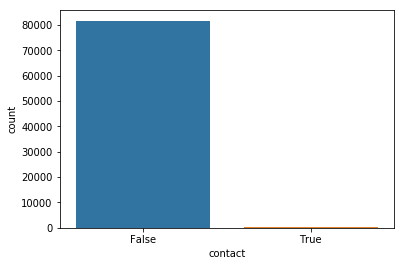

In [58]:
sns.countplot(x='contact', data=ads_click_data);

In [0]:
# # Get complete training X and y
# train_data = pd.concat([X_train, y_train], axis=1)

# # Get current data of positive and negative class
# current_pos_data = train_data[train_data['contact'] == True]
# current_neg_data = train_data[train_data['contact'] == False]

# # Define sampling ratio
# sampling_ratio = 3

# # Perform negative down sampling
# n_neg_samples = current_pos_data.shape[0] * sampling_ratio

# pos_data = current_pos_data
# neg_data = current_neg_data.sample(n=n_neg_samples, replace=True, random_state=101)
# sampling_data = pd.concat([pos_data, neg_data], axis=0)

# X_train_sampled = sampling_data.drop(columns=['contact'])
# y_train_sampled = sampling_data['contact']

In [0]:
# from imblearn.combine import SMOTEENN
# smenn = SMOTEENN()
# X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)

**Convert data set to optimized struct DMatrix**

In [0]:
ads_click_dmatrix = xgb.DMatrix(data=X, label=y)

In [62]:
params = {'objective': 'binary:logistic', 'colsample_bytree': 0.5, 'learning_rate:': 0.1, \
         'max_depth': 5, 'alpha': 10, 'n_estimators': 10}

xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train, y_train);

y_predict = xg_clf.predict(X_test)
y_pred = [round(y_hat, 0) for y_hat in y_predict]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16324
        True       0.75      0.09      0.16        33

    accuracy                           1.00     16357
   macro avg       0.87      0.55      0.58     16357
weighted avg       1.00      1.00      1.00     16357



In [0]:
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == False)) / np.sum(label == True)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)
  
cross_validation = xgb.cv(dtrain=ads_click_dmatrix, params=params, nfold=5, num_boost_round=50, \
                          early_stopping_rounds=10, metrics='error', as_pandas=True, seed=1234, fpreproc=fpreproc)

In [64]:
cross_validation.tail(1)

,train-error-mean,train-error-std,test-error-mean,test-error-std
49,0.005353,0.000909,0.006676,0.00098


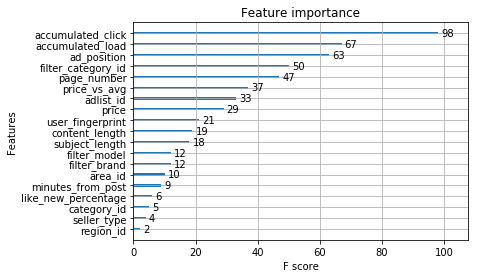

In [65]:
xgb.plot_importance(xg_clf);

In [0]:
# Import dependencies for authentication and uploading via PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Export preprocessed data to local files
ads_stats_data.to_csv('preprocess_stats.csv')
ads_info_data.to_csv('preprocess_info.csv')
ads_params_data.to_csv('preprocess_params.csv')

file_names = ['preprocess_stats.csv', 'preprocess_info.csv', 'preprocess_params.csv']

In [0]:
# Upload to file to drive (no specific parent folder)
for name in file_names:
  file = drive.CreateFile()
  file.SetContentFile(name)
  file.Upload()

In [69]:
print(ads_info_data.shape)
print(ads_params_data.shape)
print(ads_stats_data.shape)

(63394, 13)
(63381,)
(81787, 18)
